In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [ ]:
# Loading embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [35]:
# Set device (I have Apple M1 GPU, if you have CUDA GPU, you can change 'mps' to 'cuda')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [ ]:
# Prepare data
df = pd.read_csv('book_data_cleaned.csv')  # Load your cleaned data
descriptions = df['Description_Cleaned'].tolist()

y_multilabel = np.load('y_multilabel.npy')  # Or create as in your original notebook
n_unique_labels = y_multilabel.shape[1]

# Frozen Embedding

In [ ]:
# Description Embedding
print("Generating description embeddings...")
descriptions = df['Description_Cleaned'].tolist()
frozen_description_embeddings = embedding_model.encode(descriptions, 
                                     show_progress_bar=True,
                                     batch_size=32)

# Save embeddings
np.save('frozen_description_embeddings.npy', frozen_description_embeddings)
print(f"Shape: {frozen_description_embeddings.shape}")

In [ ]:
# put all unique labels in a list, given each hypernym_label column has a list of labels for each book
unique_labels = sorted(df['Hypernym_Label'].explode().dropna().unique().tolist())

label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

In [ ]:
# Generate label embeddings
frozen_label_embeddings = embedding_model.encode(unique_labels,
                                show_progress_bar=True)

# Save embeddings
np.save('frozen_label_embeddings.npy', frozen_label_embeddings)
np.save('label_to_idx.npy', label_to_idx)
print(f"Shape: {frozen_label_embeddings.shape}")

# Unfrozen Embedding

## Create Dataset

In [3]:
class BookDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    descriptions, y_multilabel, test_size=0.2, random_state=42
)

In [8]:
train_dataset = BookDataset(X_train, y_train)
test_dataset = BookDataset(X_test, y_test)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # No need to shuffle test data

## Define Models

In [23]:
class UnfrozenSBERTClassifier(nn.Module):
    def __init__(self, n_labels, dropout=0.3):
        super().__init__()
        # Load Sentence-BERT (will be trainable/unfrozen)
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2')
        embedding_dim = 384
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, n_labels)
        )
    
    def forward(self, texts):
        # Generate embeddings and clone to make them trainable
        embeddings = self.encoder.encode(texts, convert_to_tensor=True, show_progress_bar=False)
        embeddings = embeddings.clone().detach().requires_grad_(True)  # Fix the inference mode issue
        
        # Classify
        logits = self.classifier(embeddings)
        return logits, embeddings

## Finetune Embedding

In [ ]:
model = UnfrozenSBERTClassifier(n_labels=n_unique_labels).to(device)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 5e-5}, 
    {'params': model.classifier.parameters(), 'lr': 5e-4} 
])


In [36]:
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    batch_count = 0
    
    for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        labels = labels.to(device)
        
        # Batch processing - process texts in smaller chunks if needed
        # (handles memory for large text batches)
        batch_size = len(texts)
        chunk_size = 8  # Process 8 texts at a time through encoder
        all_logits = []
        
        for i in range(0, batch_size, chunk_size):
            chunk_texts = texts[i:i+chunk_size]
            logits_chunk, _ = model(chunk_texts)
            all_logits.append(logits_chunk)
        
        # Combine all chunks
        logits = torch.cat(all_logits, dim=0)
        
        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        batch_count += 1
    
    avg_loss = total_loss / batch_count
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        val_loss = 0
        val_count = 0
        
        with torch.no_grad():
            for texts, labels in test_loader:
                labels = labels.to(device)
                
                # Batch process validation too
                batch_size = len(texts)
                chunk_size = 8
                all_logits = []
                
                for i in range(0, batch_size, chunk_size):
                    chunk_texts = texts[i:i+chunk_size]
                    logits_chunk, _ = model(chunk_texts)
                    all_logits.append(logits_chunk)
                
                logits = torch.cat(all_logits, dim=0)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                val_count += 1
        
        avg_val_loss = val_loss / val_count
        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")


print("Training complete!")

Epoch 1/5: 100%|██████████| 1633/1633 [04:41<00:00,  5.80it/s]


Epoch 1 - Average Loss: 0.0068
Epoch 1 - Validation Loss: 0.0067


Epoch 2/5: 100%|██████████| 1633/1633 [04:47<00:00,  5.68it/s]


Epoch 2 - Average Loss: 0.0065
Epoch 2 - Validation Loss: 0.0065


Epoch 3/5: 100%|██████████| 1633/1633 [04:37<00:00,  5.88it/s]


Epoch 3 - Average Loss: 0.0064
Epoch 3 - Validation Loss: 0.0064


Epoch 4/5: 100%|██████████| 1633/1633 [04:39<00:00,  5.83it/s]


Epoch 4 - Average Loss: 0.0062
Epoch 4 - Validation Loss: 0.0063


Epoch 5/5: 100%|██████████| 1633/1633 [04:42<00:00,  5.78it/s]


Epoch 5 - Average Loss: 0.0061
Epoch 5 - Validation Loss: 0.0063
Training complete!


In [37]:
def evaluate_model(model, test_loader, device, threshold=0.5):
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc="Evaluating"):
            labels = labels.to(device)
            
            # Forward pass
            logits, _ = model(texts)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Convert logits to probabilities
            probs = torch.sigmoid(logits)
            
            # Convert probabilities to binary predictions
            predictions = (probs > threshold).float()
            
            all_predictions.append(predictions.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all batches
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    
    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    
    # Multi-label metrics
    hamming = hamming_loss(all_labels, all_predictions)
    
    # Per-sample accuracy (exact match)
    exact_match = accuracy_score(all_labels, all_predictions)
    
    # Label-wise metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro', zero_division=0
    )
    
    # Micro-averaged metrics (treats each label prediction independently)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='micro', zero_division=0
    )
    
    # Subset accuracy (percentage of samples with all labels correct)
    subset_accuracy = (all_predictions == all_labels).all(axis=1).mean()
    
    return {
        'test_loss': avg_loss,
        'hamming_loss': hamming,
        'exact_match_accuracy': exact_match,
        'subset_accuracy': subset_accuracy,
        'macro_precision': precision,
        'macro_recall': recall,
        'macro_f1': f1,
        'micro_precision': precision_micro,
        'micro_recall': recall_micro,
        'micro_f1': f1_micro
    }

# Evaluate the model - check for overfitting
results = evaluate_model(model, test_loader, device, threshold=0.5)

print("Test Results:")
print(f"Test Loss: {results['test_loss']:.4f}")
print(f"Hamming Loss: {results['hamming_loss']:.4f}")
print(f"Exact Match Accuracy: {results['exact_match_accuracy']:.4f}")
print(f"Subset Accuracy: {results['subset_accuracy']:.4f}")
print(f"Macro F1: {results['macro_f1']:.4f}")
print(f"Micro F1: {results['micro_f1']:.4f}")
print(f"Macro Precision: {results['macro_precision']:.4f}")
print(f"Macro Recall: {results['macro_recall']:.4f}")

Evaluating: 100%|██████████| 409/409 [01:05<00:00,  6.21it/s]


Test Results:
Test Loss: 0.0063
Hamming Loss: 0.0019
Exact Match Accuracy: 0.1354
Subset Accuracy: 0.1354
Macro F1: 0.0528
Micro F1: 0.4883
Macro Precision: 0.1151
Macro Recall: 0.0407


## Generate Unfrozen Embeddings

In [38]:
model.eval()
all_embeddings = []

with torch.no_grad():
    for texts, _ in tqdm(DataLoader(train_dataset + test_dataset, batch_size=32), 
                         desc="Generating embeddings"):
        _, embeddings = model(texts)
        all_embeddings.append(embeddings.cpu().numpy())

description_embeddings_unfrozen = np.vstack(all_embeddings)
np.save('unfrozen_description_embeddings.npy', description_embeddings_unfrozen)
print(f"Unfrozen description embeddings saved: {description_embeddings_unfrozen.shape}")


Generating embeddings: 100%|██████████| 2041/2041 [05:31<00:00,  6.16it/s]

Unfrozen embeddings saved: (65296, 384)


In [39]:
label_embeddings_unfrozen = model.classifier[-1].weight.data.cpu().numpy()
np.save('unfrozen_label_embeddings.npy', label_embeddings_unfrozen)
print(f"Unfrozen label embeddings saved: {label_embeddings_unfrozen.shape}")

Unfrozen label embeddings saved: (931, 512)


# Prototype Representation

In [51]:
# For each label, average embeddings of all books with that label
label_embeddings_avg = np.zeros((n_unique_labels, 384))

for label_idx in range(n_unique_labels):
    # Find books with this label
    book_indices = np.where(y_multilabel[:, label_idx] == 1)[0]
    
    if len(book_indices) > 0:
        # Average their embeddings
        label_embeddings_avg[label_idx] = description_embeddings_unfrozen[book_indices].mean(axis=0)

np.save('label_embeddings_prototype.npy', label_embeddings_avg)
print(f"label_embeddings_prototype saved: {label_embeddings_avg.shape}")

label_embeddings_prototype saved: (931, 384)


# Embedding Comparison

In [54]:
# Load all embeddings
description_embeddings_frozen = np.load('frozen_description_embeddings.npy')  # Original frozen
description_embeddings_unfrozen = np.load('unfrozen_description_embeddings.npy')
label_embeddings_frozen = np.load('frozen_label_embeddings.npy')
label_embeddings_unfrozen = np.load('unfrozen_label_embeddings.npy')
label_embeddings_prototype = np.load('label_embeddings_prototype.npy')

In [55]:
# Use test set for evaluation
test_indices = list(range(len(X_train), len(descriptions)))
y_test_eval = y_multilabel[test_indices]

## 1: Frozen Embedding + Clasification Head

In [56]:
# Train a simple classifier on frozen embeddings

X_train_frozen = description_embeddings_frozen[:len(X_train)]
X_test_frozen = description_embeddings_frozen[test_indices]

frozen_classifier = MLPClassifier(hidden_layer_sizes=(512,), max_iter=20, random_state=42)
frozen_classifier.fit(X_train_frozen, y_train)
y_pred_frozen = frozen_classifier.predict(X_test_frozen)

recall_frozen = recall_score(y_test_eval, y_pred_frozen, average='samples', zero_division=0)
precision_frozen = precision_score(y_test_eval, y_pred_frozen, average='samples', zero_division=0)
f1_frozen = f1_score(y_test_eval, y_pred_frozen, average='samples', zero_division=0)

print(f"  Per-sample Recall: {recall_frozen:.4f}")
print(f"  Per-sample Precision: {precision_frozen:.4f}")
print(f"  Per-sample F1: {f1_frozen:.4f}\n")

/Users/yifeishi/Desktop/NEU/fall 2025/CS 6120/Project/nlp_project/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


  Per-sample Recall: 0.0000
  Per-sample Precision: 0.0000
  Per-sample F1: 0.0000



## 2. Unfrozen Embedding + Classification Head

In [57]:
X_test_unfrozen = description_embeddings_unfrozen[test_indices]

# Get predictions from trained model
model.eval()
y_pred_unfrozen = []

with torch.no_grad():
    for i in range(0, len(X_test), 32):
        batch_texts = X_test[i:i+32]
        logits, _ = model(batch_texts)
        preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
        y_pred_unfrozen.append(preds)

y_pred_unfrozen = np.vstack(y_pred_unfrozen)

recall_unfrozen = recall_score(y_test_eval, y_pred_unfrozen, average='samples', zero_division=0)
precision_unfrozen = precision_score(y_test_eval, y_pred_unfrozen, average='samples', zero_division=0)
f1_unfrozen = f1_score(y_test_eval, y_pred_unfrozen, average='samples', zero_division=0)

print(f"  Per-sample Recall: {recall_unfrozen:.4f}")
print(f"  Per-sample Precision: {precision_unfrozen:.4f}")
print(f"  Per-sample F1: {f1_unfrozen:.4f}\n")


  Per-sample Recall: 0.0483
  Per-sample Precision: 0.0825
  Per-sample F1: 0.0577



## Prototype Representation (Similarity-based)

In [58]:
# Calculate cosine similarity between test embeddings and prototypes
similarities = cosine_similarity(X_test_unfrozen, label_embeddings_prototype)

# Threshold: predict label if similarity > 0.5 (adjustable)
threshold = 0.5
y_pred_prototype = (similarities > threshold).astype(int)

recall_prototype = recall_score(y_test_eval, y_pred_prototype, average='samples', zero_division=0)
precision_prototype = precision_score(y_test_eval, y_pred_prototype, average='samples', zero_division=0)
f1_prototype = f1_score(y_test_eval, y_pred_prototype, average='samples', zero_division=0)

print(f"  Per-sample Recall: {recall_prototype:.4f}")
print(f"  Per-sample Precision: {precision_prototype:.4f}")
print(f"  Per-sample F1: {f1_prototype:.4f}\n")

  Per-sample Recall: 0.1095
  Per-sample Precision: 0.0165
  Per-sample F1: 0.0121



In [60]:
results_df = pd.DataFrame({
    'Method': ['Frozen SBERT', 'Unfrozen SBERT', 'Prototype'],
    'Recall': [recall_frozen, recall_unfrozen, recall_prototype],
    'Precision': [precision_frozen, precision_unfrozen, precision_prototype],
    'F1-Score': [f1_frozen, f1_unfrozen, f1_prototype]
})

results_df

,Method,Recall,Precision,F1-Score
0,Frozen SBERT,0.000000,0.000000,0.000000
1,Unfrozen SBERT,0.048264,0.082513,0.057745
2,Prototype,0.109548,0.016532,0.012111


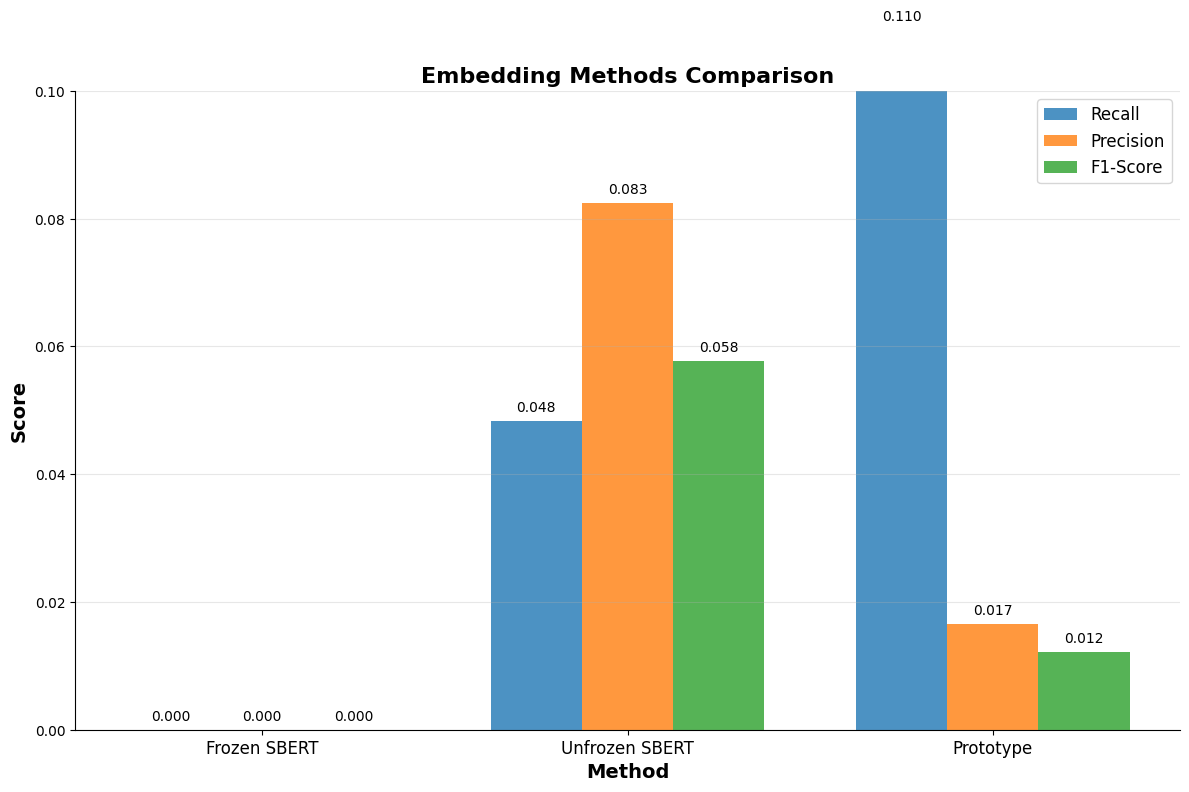


Numerical Results:
        Method   Recall  Precision  F1-Score
  Frozen SBERT 0.000000   0.000000  0.000000
Unfrozen SBERT 0.048264   0.082513  0.057745
     Prototype 0.109548   0.016532  0.012111


In [62]:
# Visualize comparison - all metrics in one plot

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

methods = results_df['Method'].values
metrics = ['Recall', 'Precision', 'F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Set up bar positions
x = np.arange(len(methods))
width = 0.25

# Create bars for each metric
for i, (metric, color) in enumerate(zip(metrics, colors)):
    values = results_df[metric].values
    bars = ax.bar(x + i * width, values, width, label=metric, color=color, alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Embedding Methods Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 0.1)
ax.set_xticks(x + width)
ax.set_xticklabels(methods, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Add some styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('embedding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Also print the numerical results for reference
print("\nNumerical Results:")
print(results_df.to_string(index=False))